# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [28]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [29]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [30]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [31]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../data/moviereviews_train.tsv', my_random_seed=73)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [32]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 5047, 'TN': 5104, 'FP': 4896, 'FN': 4953, 'Accuracy': 0.50755, 'Precision': 0.5075932817057226, 'Recall': 0.5047, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [33]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [34]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [35]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 9602, 'TN': 9847, 'FP': 153, 'FN': 398, 'Accuracy': 0.97245, 'Precision': 0.984315735520246, 'Recall': 0.9602, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [36]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [37]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 10000, 'TN': 10000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [41]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10000, 'Neg': 10000, 'TP': 8286, 'TN': 7246, 'FP': 2754, 'FN': 1714, 'Accuracy': 0.7766, 'Precision': 0.7505434782608695, 'Recall': 0.8286, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

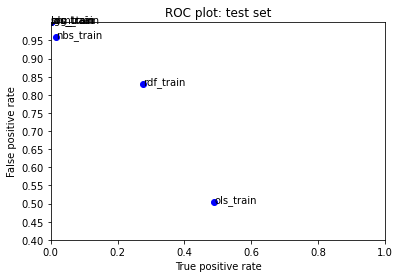

In [44]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

# fits = [svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train]
#ols_performance_train
#rdf_performance_train
fig = plt.subplots(figsize=(6, 4))

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0.4, 1])
plt.yticks(np.arange(0.4, 1, 0.05))
plt.title('ROC plot: test set')
plt.ylabel('False positive rate')
plt.xlabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [45]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [46]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
21
while being one of the \stars\" of this film doesn't necessarily give me sage insight, i do know quite a bit of what was first there...and what ended up on the screen. i remember seeing the original cut of \"incoming freshman\" and being very pleased. it was funny, sexy, raunchy, all the main requirements of a drive-in film. you have to remember this was shot and released before all the rest...animal house, porky's, etc...so in its own way, this flick was truly ahead of its time. for whatever reasons, the film was given to the main distributors who editing out half the original film, and then edited in (should i say \"shuffled?\") THE most random scenes ever. the fat guy, the people with goat heads....what the heck was all that?! i'm sure it was put in for additional T&A, but it was so slowly paced, it caused anything going on prior to it to grind to a screeching and painful halt. but all in all, it's a fun memory for me...especially in that i'm able to 

4843
My god, what's going on? a Uwe Boll film and positive comments? Wow!<br /><br />Nice to note that most of the positive reviews are coming from newbies to Boll's work. I myself, as I have stated in previous Uwe Boll reviews, only watch his films in the hope that one day he will actually make something good. I mean..IT MUST HAPPEN ONE DAY!<br /><br />Alas, Seed is not that day. I don't quite know where to start with the lame attempt at a horror film that Seed is. The thing to remember people is that all the sickos in the world are that way due to having watched various sick acts on video or the net.....or so Mr Boll believes. I still can't for the life of me figure out why footage of real animal abuse and killings was needed in the first 10 minutes of this film. I understand the concept that Seed (the killer) is a sicko and enjoys watching such stuff.....but can't understand why Mr Boll thought putting REAL footage in the film would work. Maybe to shock us? Hmmm.....well, I for one 

9030
I picked this movie up to replace the dismal choice of daytime television and to go with my thirst for femme fatales. Well, for the previous, it is better than daytime television....though I'm not sure how much.<br /><br />It does have its points but after about the first 20-30 minutes, the good points pan out and one comes to the conclusion that they are watching a made for TV movie that was put together with not much time to make something that will hold together. In short, a terrible Sci Fi channel type movie.<br /><br />It has its points such as the future is dirty, like \Blade Runner\" showed ..... of course, this is no \"Blade Runner\". The Captain looks, sort of feels like actor Robert Forster, the kind of person one might want to be around.<br /><br />But unfortunately, it rather ends up feeling like a bad \"Andromeda\" rehash where the muscle of the crew consists of poor copies of the smart gunners of \"Aliens\", the mystic is vampire Willow sexually intensified, and the 

12735
That might be a bit harsh for me saying that, but sadly so far in his directing career its true. Just have a look at what he as done so far. They barely make it past the 3 star mark.<br /><br />Why did I watch this movie? 2 reasons. Lucy Lawless and Heroes star Greg Grunberg. Lucy was outstanding in this movie, her performance carries the whole movie. I do hope she gets a \blockbuster\" and breaks into the bigger league of actors, she clearly has the skills. Greg was not so impressive, typical TV acting style.<br /><br />The movie is oddly categorized as a horror. The only \"horror\" is short flashbacks, and they last a max of 2-5 seconds with a little blood in them. I personally would call this more a \"drama/thriller\".<br /><br />But no matter how interesting the story actually is, bad directing, editing and acting (appart from Lucy) destroys it. You get no real connection to the actors, something which is very important in a story like this one. You just sit there watching fe

16509
This is is a thoroughly unpleasant, if slickly made, movie. I tried it because it stars Richard Dreyfus and Jeff Goldblum, two good actors, and because the plot line - a mob boss is about to be released from a mental institution - sounded promising. The movie is billed as a comedy, sorta. What we have is an endless series of shots - you should pardon the pun - of people in dimly lit and elegant, if somewhat surreal, interiors, shooting each other - in the head, stomach, kneecap, foot, heart (no part of the anatomy is avoided, it seems) while uttering vague and cryptic dialogue, some of which is supposed, evidently, to be humorous in a sort of post-modern way. Goldblum's dialogue for the whole movie could fit on a 3x5 card, and he wears a single facial expression - a sardonic grin - throughout. Ellen Barkin and Gregory Hines do the best they can. Burt Reynolds does a cameo. The credits list Rob Reiner and Joey Bishop, but I somehow missed them (good move on their part). The whole 

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [47]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 1239, 'TN': 1280, 'FP': 1220, 'FN': 1261, 'Accuracy': 0.5038, 'Precision': 0.5038633590890605, 'Recall': 0.4956, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [48]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2054, 'TN': 2095, 'FP': 405, 'FN': 446, 'Accuracy': 0.8298, 'Precision': 0.83529890199268, 'Recall': 0.8216, 'desc': 'svm_test'}


### MODEL: logistic regression

In [49]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2063, 'TN': 2117, 'FP': 383, 'FN': 437, 'Accuracy': 0.836, 'Precision': 0.8434178250204415, 'Recall': 0.8252, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [50]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 1852, 'TN': 1877, 'FP': 623, 'FN': 648, 'Accuracy': 0.7458, 'Precision': 0.7482828282828283, 'Recall': 0.7408, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [51]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2083, 'TN': 2125, 'FP': 375, 'FN': 417, 'Accuracy': 0.8416, 'Precision': 0.8474369406021155, 'Recall': 0.8332, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [52]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2066, 'TN': 2010, 'FP': 490, 'FN': 434, 'Accuracy': 0.8152, 'Precision': 0.8082942097026604, 'Recall': 0.8264, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [53]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2500, 'Neg': 2500, 'TP': 2031, 'TN': 1819, 'FP': 681, 'FN': 469, 'Accuracy': 0.77, 'Precision': 0.7488938053097345, 'Recall': 0.8124, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

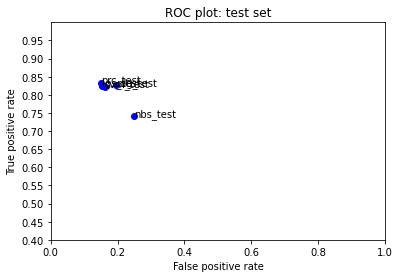

In [54]:
# fits =[svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test]

fits = [svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test]

# rdf_performance_test
# ols_performance_test
fig = plt.subplots(figsize=(6, 4))

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0.4, 1])
plt.yticks(np.arange(0.4, 1, 0.05))
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [27]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/moviereviews_test.tsv', my_random_seed=74, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

FileNotFoundError: [Errno 2] No such file or directory: '/home/ec2-user/data/moviereviews_test.tsv'

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.5596


In [25]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5
1,8348_2,This movie is a disaster within a disaster fil...,169,15
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18
3,7186_2,Afraid of the Dark left me with the impression...,112,5
4,12128_7,A very accurate depiction of small time mob li...,133,8


In [26]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,1
2,5828_4,1
3,7186_2,1
4,12128_7,0


In [27]:
my_submission.shape

(25000, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation